In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
from utils.fractional_diff import calc_min_d, fast_frac_diff
from tqdm.contrib import tenumerate

mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14


In [2]:
ticker = 'AAPL'
n_cpus = 8
data_path = Path('data/aapl_dollar_bars.h5')

# pd.options.display.max_rows = 4000
# pd.options.display.max_seq_items = 2000

In [3]:
bars = pd.read_hdf(data_path.resolve(), key='key')
bars.drop(['tick_num', 'cum_buy_volume', 'cum_ticks', 'cum_dollar_value'], axis=1, inplace=True)
bars.set_index('date_time', inplace=True)
bars = bars[~bars.index.duplicated()]

display(bars.head())

,open,high,low,close,volume
date_time,,,,,
2019-11-07 16:28:57.758,259.7026,259.7700,259.48,259.66,320759.0
2019-11-07 16:37:26.188,259.6600,259.8500,259.61,259.73,320271.0
2019-11-07 16:46:59.795,259.7300,259.7453,259.50,259.50,321204.0
2019-11-07 16:54:07.176,259.5000,259.6000,259.13,259.18,320711.0
2019-11-07 16:59:24.869,259.1800,259.9500,259.07,259.55,320834.0


## Fractional Differentiation

In [4]:
def calc_fractional_diff(df: pd.DataFrame, thresh: np.float64=1e-3) -> pd.DataFrame:
    cols = ['open', 'high', 'low', 'close']
    diffed_df = df.copy(deep=True)[cols]
    
    if diffed_df.index.name == 'date_time':
        diffed_df.reset_index(inplace=True)

    min_d = calc_min_d(diffed_df['close'], col_name='close', thresh=thresh)
    if min_d is None:
        min_d = calc_min_d(diffed_df['close'].cumsum(), col_name='close', thresh=thresh)
        if min_d is None:
            return 0, df
        
    for _, col in tenumerate(cols, desc='Differentiating'):
        diffed_series = fast_frac_diff(diffed_df[col], diff_amt=min_d, col_name=col, thresh=thresh).dropna()
        diffed_df.drop(col, axis=1, inplace=True)
        diffed_df.loc[:, col] = diffed_series

    if 'volume' in df.columns:
        diffed_df = pd.concat([diffed_df, df.loc[:, 'volume'].reset_index(drop=True)], axis=1)

    if 'date_time' in diffed_df.columns:
        diffed_df.set_index('date_time', drop=True, inplace=True)
    return min_d, diffed_df


In [5]:
min_d, diffed_bars = calc_fractional_diff(bars, thresh=1e-4)
diffed_bars = diffed_bars.dropna()


Differentiating:   0%|          | 0/4 [00:00<?, ?it/s]

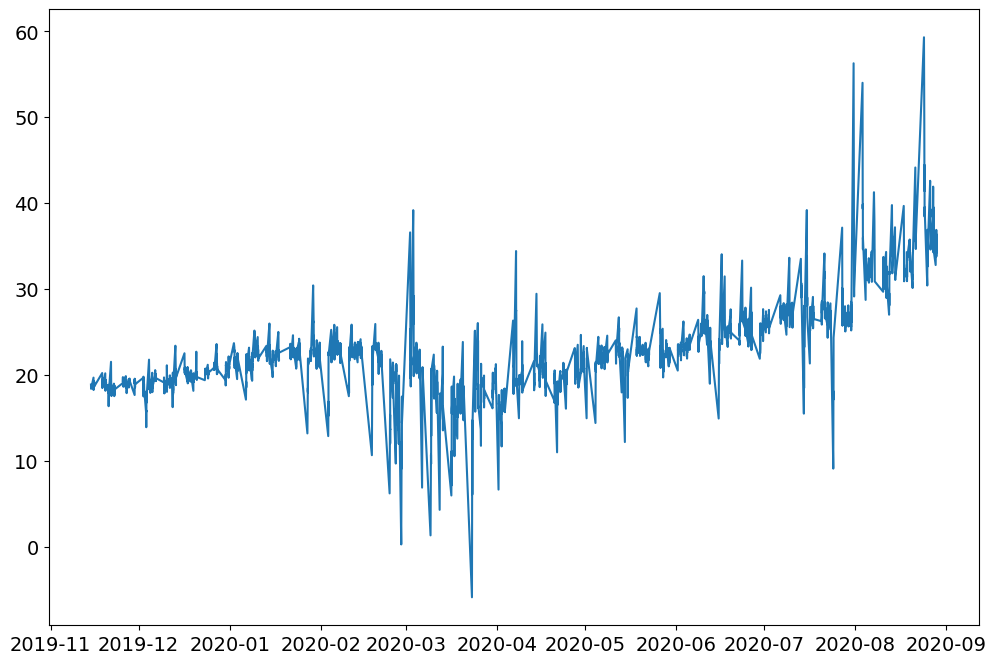

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(diffed_bars.index, diffed_bars['close'])
plt.show()

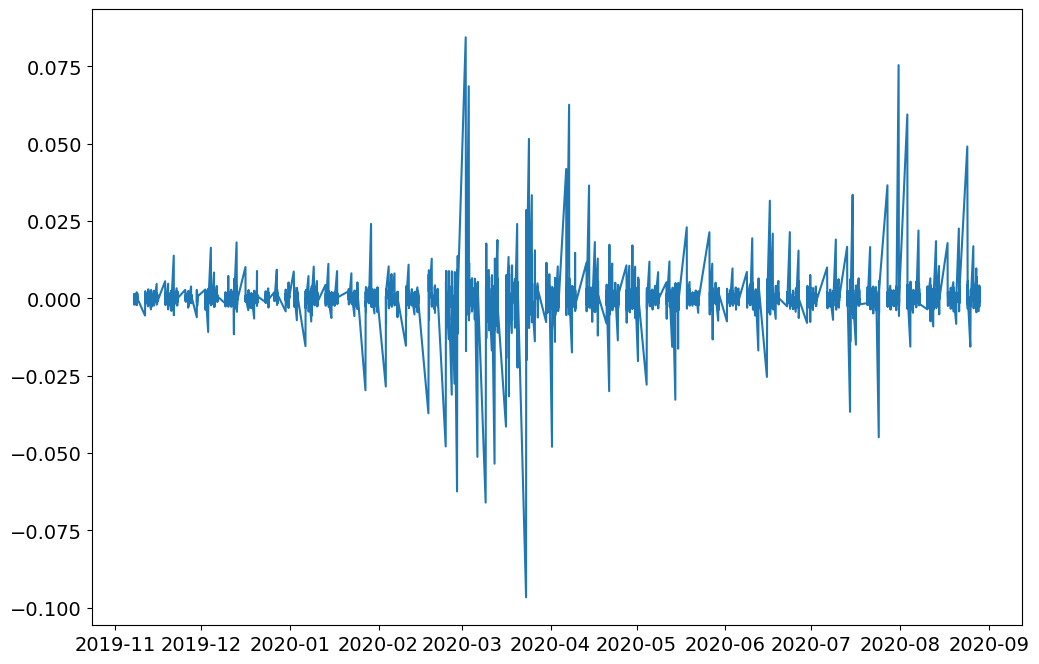

In [7]:
plt.figure(figsize=(12, 8))
returns = bars['close'].copy(deep=True).pct_change().dropna()
plt.plot(returns)
plt.show()